# Overview

The LightweightMMM package (built using Numpyro and JAX) helps advertisers easily build Bayesian MMM models by providing the functionality to appropriately scale data, evaluate models, optimise budget allocations and plot common graphs used in the field.

##### Simplified Model Overview

An MMM quantifies the relationship between media channel activity and sales, while controlling for other factors. A simplified model overview is shown below. An MMM is typically run using weekly level observations (e.g. the KPI could be sales per week), however, it can also be run at the daily level.

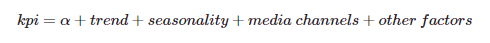


Where:

1."kpi" is typically the volume or value of sales per time period

2."alpha" is the model intercept

3."trend" is a flexible non-linear function that captures trends in the data

4."seasonality" is a sinusoidal function with configurable parameters that flexibly captures seasonal trends

5."media" is a matrix of different media channel activity (typically impressions or costs per time period) which receives transformations depending on the model used

6."other factore" is a matrix of other factors that could influence sales.

In [3]:
"""

Install Pip dependencies

"""
# First would be to install lightweight_mmm
# !pip install --upgrade lightweight_mmm --user

# -- Load older versions of the following libraries
# !pip install --upgrade numpyro==0.13.2 --user
# !pip install --upgrade jax==0.4.23 --user
# !pip install --upgrade jaxlib==0.4.23 --user

# !pip install --upgrade memory_profiler --user
# !pip install --upgrade worker --user
# !pip install --upgrade scipy==1.12.0 --user

# !pip install --upgrade prophet --user

'\n\nInstall Pip dependencies\n\n'

# 1.Import Libraries

In [4]:
"""
Import Lightweight MMM Libraries

"""

# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils


# importing the library
# from memory_profiler import profile
     

In [5]:
"""
Import required libraries

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score,precision_score,recall_score
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.metrics import RocCurveDisplay,roc_curve,auc
from xgboost import XGBClassifier,XGBRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
import time
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification
import re

import shap
from pprint import pprint

# For ordinal encoding categorical variables, splitting data
from tqdm import tqdm

#Import 'scope' from hyperopt in order to obtain int values for certain hyperparameters.
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

import arviz

from IPython.display import display, HTML
display(HTML("<st yle>.container { width:80% !important; }</style>"))

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

import warnings
warnings.filterwarnings('ignore')

# 2.Define Functions

In [6]:
class data_pre_processing():
    """
    Pre process pandas dataframes
    """
    
    def df_description(df):
        print('shape : ',df.shape)
        print('dtypes :','\n',df.dtypes)
        return None

    def convert_col_names_to_lower_case(df):
        for col in df.columns:
            df = df.rename(columns = {col:col.lower()})
        return df
    
    def describe_data(df):
        display(df.describe(include='all'))
        return None
    
    def data_info(df):
        display(df.info(verbose=True, show_counts=True))
        return None

    def nulls_in_data(df):
        print(df.isnull().sum())
        return None
    
    def duplicate_rows_at_primary_key_level(df,level_of_the_data :list):
        
        df = df[df.duplicated(subset=level_of_the_data, keep=False)]
        if df.shape[0] >0:
            print(" Dataframe has duplicates, total rows with duplicates :",df.shape[0])
        else:
            print(" No duplicates in data")      
        return df
    
    def percentage_nulls_in_each_col(df):
        """
        Return a DF of total null percentage in each column
        Args:
            df (Dataframe): Input DF
        """
        NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (df.isna().sum()/df.shape[0]*100).tolist()],df.dtypes.tolist()], 
           columns=df.columns, index=['NA Count', 'NA Percent','Dtypes']).transpose()
        display(NA)
        
        return None

        
            
    def drop_cols(df,column_list_to_drop):
        """

        Args:
            df (Dataframe): Input Dataframe
            column_list_to_drop (List of Columns): List of columns to be dropped from DF
            
        Result :
            df with updated columns post dropping.
        """
        
        return df.drop(columns = column_list_to_drop)
    
    def df_columns_and_dtypes_into_list(df) -> dict:
        """

        Returns Dataframe columns and respcetive dtypes as a dictionary.
        Args:
            df (Dataframe): Input Dataframe

        Returns:
            dict: {col1:dtype,col2:dtype2}
        """
        
        return {df.columns.tolist()[i] : str(df.dtypes.tolist()[i]) for i in range(len(df.columns)) }
    
    
    def convert_dtypes_from_dict(df, col_to_dtype_mapping_dict : dict ):
        """
        df : Input Dataframe
        col_to_dtype_mapping_dict: {column:dtype}
        
        return : df with updated dtypes
        
        """
        print('Converting Column Datatypes')
        for col,dtype in col_to_dtype_mapping_dict.items():
            try:
                if col in df.columns:
                    if dtype == 'string':
                        df[col] = df[col].astype(str)
                    elif dtype == 'int':
                        df[col] = df[col].astype(int)
                    elif dtype == 'float':
                        df[col] = df[col].astype(float)
                    elif dtype == 'datetime':
                        df[col] = pd.to_datetime(df[col])
            except Exception as e:
                print('Error processing : ',col, ' ; ',e)
        return df
    


    def ydata_profiling(df):
        """
        Run ydata_profile library for data
        Args:
            df (Dataframe): Df to be profiled

        Returns:
            _type_: _description_
        """
        # !pip install ydata-profiling --ignore-installed llvmlite --user
        # from ydata_profiling import ProfileReport
        # or
        # !pip install ydata-profiling==4.1.2
        # !pip install pydantic==2.6.0 --user
        from ydata_profiling import ProfileReport
        profile = ProfileReport(df)
        
        return profile
    


    def process_nulls_in_df(df,null_columns)-> pd.core.frame.DataFrame:
        """_summary_

        Args:
            df (_type_): _description_
            null_columns (_type_): _description_

        Returns:
            pd.core.frame.DataFrame: _description_
        """
    

        
        return None
    
def plot_line_charts_with_lags(df, x_variable, y_variable='sales'):
    """
    Creates a 1x3 matrix of line charts with the specified x variable and sales over time,
    including charts with 1-week and 2-week lags for the x variable, all scaled based on Z-scores.

    Args:
    - df (DataFrame): The dataset containing the variables.
    - x_variable (str): The name of the x variable to plot against time.
    - y_variable (str): The name of the y variable, default is 'sales'.
    """

    # Ensuring the date column is in datetime format
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])

    # Creating lagged variables
    df[f'{x_variable}_lag1'] = df[x_variable].shift(-1)
    df[f'{x_variable}_lag2'] = df[x_variable].shift(-2)

    # Scaling the variables based on Z-scores
    scaler = StandardScaler()
    scaled_vars = scaler.fit_transform(df[[y_variable, x_variable, f'{x_variable}_lag1', f'{x_variable}_lag2']].dropna())
    df_scaled = pd.DataFrame(scaled_vars, columns=[y_variable, x_variable, f'{x_variable}_lag1', f'{x_variable}_lag2'])

    # Setting up the figure for plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Because scaling and shifting may lead to a different number of rows, we need to align the date index.
    dates = df['week_start_date'][-len(df_scaled):]

    # Original variable line chart
    axes[0].plot(dates, df_scaled[y_variable], label=y_variable, color='blue')
    axes[0].plot(dates, df_scaled[x_variable], label=x_variable, color='red')
    axes[0].set_title(f'Original {y_variable} and {x_variable} (Scaled)')
    axes[0].legend(loc='upper left')

    # 1-week lag line chart
    axes[1].plot(dates, df_scaled[y_variable], label=y_variable, color='blue')
    axes[1].plot(dates, df_scaled[f'{x_variable}_lag1'], label=f'{x_variable} (1-week lag)', color='red')
    axes[1].set_title(f'{y_variable} and 1-week Lag of {x_variable} (Scaled)')
    axes[1].legend(loc='upper left')

    # 2-week lag line chart
    axes[2].plot(dates, df_scaled[y_variable], label=y_variable, color='blue')
    axes[2].plot(dates, df_scaled[f'{x_variable}_lag2'], label=f'{x_variable} (2-week lag)', color='red')
    axes[2].set_title(f'{y_variable} and 2-week Lag of {x_variable} (Scaled)')
    axes[2].legend(loc='upper left')

    
    for ax in axes:
        ax.set_xlabel('Date')
        ax.set_ylabel('Scaled Value')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# 3.Pre-process Data

In [7]:
"""
Read the dataset.

Four years' (209 weeks) records of sales, media impression and media spending at weekly level.

1. Media Variables

Media Impression (prefix='mdip_'): impressions of 13 media channels: direct mail, insert, newspaper, digital audio, radio, TV, digital video, social media, online display, email, SMS, affiliates, SEM.
Media Spending (prefix='mdsp_'): spending of media channels.
2. Control Variables

Macro Economy (prefix='me_'): CPI, gas price.
Markdown (prefix='mrkdn_'): markdown/discount.
Store Count ('st_ct')
Retail Holidays (prefix='hldy_'): one-hot encoded.
Seasonality (prefix='seas_'): month, with Nov and Dec further broken into to weeks. One-hot encoded.
3. Sales Variable ('sales')

"""
    



mmm_df = pd.read_csv('MMM_Data.csv')
print(mmm_df.shape)



(209, 80)


In [8]:
"""
Define new names for columns.
Re-map column names.

"""

mmm_df2 = mmm_df.copy()

mapped_columns_dict = {'mdip_':'media_impression_',\
                        'mdsp_':'media_spend_',\
                        'me_': 'macro_econ_',\
                        'mrkdn_':'markdown_discount_',\
                        'st_ct':'store_count',\
                        'wk_strt_dt':'week_start_date',\
                        'wk_in_yr_nbr':'week_in_year',\
                        'yr_nbr':'year',\
                        'qtr_nbr':'quarter',\
                        'prd':'period',\
                        'wk_nbr':'week_in_month',\
                        '_dm':'_direct_mail',\
                        '_inst':'_insert',\
                        '_nsp':'_newspaper',\
                        '_auddig':'_dig_audio',\
                        '_audtr':'_radio',\
                        '_vidtr':'_tv',\
                        '_viddig':'_dig_video',\
                        '_so':'_social_media',\
                        '_on':'_online display',\
                        '_em':'_email',\
                        '_sms':'_sms',\
                        }

datatype_mapping = {'week_start_date':'datetime'}

# Map column names
for short_form,long_form in mapped_columns_dict.items():
    for col in mmm_df2.columns:
        if short_form in col:
            new_col_name = re.sub(short_form,long_form,col)
            # print(short_form,"--> ",col,"--> ",new_col_name)
            mmm_df2 = mmm_df2.rename(columns={col:new_col_name})


# Lowercase column names
mmm_df2 = data_pre_processing.convert_col_names_to_lower_case(mmm_df2)

# String to Date conversion
mmm_df2 = data_pre_processing.convert_dtypes_from_dict(df = mmm_df2,col_to_dtype_mapping_dict=datatype_mapping)





Converting Column Datatypes


In [9]:
"""
Define continuous,categorical and target column

"""


continuous_column = [ 'media_impression_direct_mail', 'media_impression_insert',
       'media_impression_newspaper', 'media_impression_dig_audio',
       'media_impression_radio', 'media_impression_tv',
       'media_impression_dig_video', 'media_impression_social_media',
       'media_impression_online display', 'media_impression_email',
       'media_impression_sms', 'media_impression_aff', 'media_impression_sem',
       'media_spend_direct_mail', 'media_spend_insert',
       'media_spend_newspaper', 'media_spend_dig_audio', 'media_spend_radio',
       'media_spend_tv', 'media_spend_dig_video', 'media_spend_social_media',
       'media_spend_online display', 'media_spend_sem',
       'macro_econ_ics_all', 'macro_econ_gas_dpg', 'store_count',
       'markdown_discount_valadd_edw', 'markdown_discount_pdm']

one_hot_encoded_columns = ["hldy_black friday",
       "hldy_christmas day", "hldy_christmas eve", "hldy_columbus day",
       "hldy_cyber monday", "hldy_day after christmas", "hldy_easter",
       "hldy_father's day", "hldy_green monday", "hldy_july 4th",
       "hldy_labor day", "hldy_mlk", "hldy_memorial day", "hldy_mother's day",
       "hldy_nye", "hldy_new year's day", "hldy_pre thanksgiving",
       "hldy_presidents day", "hldy_prime day", "hldy_thanksgiving",
       "hldy_valentine's day", "hldy_veterans day",
       #  "seas_period_1",
       # "seas_period_2", "seas_period_3", "seas_period_4", "seas_period_5",
       # "seas_period_6", "seas_period_7", "seas_period_8", "seas_period_9",
       # "seas_period_12", "seas_week_40", "seas_week_41", "seas_week_42",
       # "seas_week_43", "seas_week_44", "seas_week_45", "seas_week_46",
       # "seas_week_47", "seas_week_48"
       ]

date_columns = ['week_start_date', 'year', 'quarter', 'period', 'week_in_month','week_in_year']

target_column = ["sales"]

""""

Lightweight mmm columns

"""

media_spend_cols = [ 'media_spend_direct_mail', 'media_spend_insert',
       'media_spend_newspaper', 'media_spend_dig_audio', 'media_spend_radio',
       'media_spend_tv', 'media_spend_dig_video', 'media_spend_social_media',
       'media_spend_online display', 'media_spend_sem']


media_impression_cols = [ 'media_impression_direct_mail', 'media_impression_insert',
       'media_impression_newspaper', 'media_impression_dig_audio',
       'media_impression_radio', 'media_impression_tv',
       'media_impression_dig_video', 'media_impression_social_media',
       'media_impression_online display', 'media_impression_sem']


extra_features_cols = ['macro_econ_ics_all', 'macro_econ_gas_dpg', 'store_count',
       'markdown_discount_valadd_edw', 'markdown_discount_pdm']+one_hot_encoded_columns

# 4.Train-Test Split

In [10]:
"""
Train test split - Use time-series split as marketing spend data is Longitudnal in nature. 

"""


"""

Time-series Split -->

"""
tss = TimeSeriesSplit(n_splits = 4)

mmm_df2_time_series = mmm_df2.copy()
mmm_df2_time_series.set_index('week_start_date', inplace=True)
mmm_df2_time_series.sort_index(inplace=True)

independant_columns = [i for i in continuous_column+one_hot_encoded_columns+date_columns if 'week_start_date' not in i]
X = mmm_df2_time_series[independant_columns]
y = mmm_df2_time_series[target_column]

# Add 0.01 to each numerical value for lightweight mmm
for col in X.columns:
    if col in continuous_column:
        X[col] = X[col] + 0.1

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


print(X_train.shape,X_test.shape)




"""

Regular Split -->

"""

# independant_columns = [i for i in continuous_column+one_hot_encoded_columns+date_columns if 'week_start_date' not in i ]
# X = mmm_df2[independant_columns]
# y = mmm_df2[target_column]

# # Using the train test split function
# X_train, X_test, y_train, y_test = train_test_split(
#   X,y , random_state=104,test_size=0.25, shuffle=True)

# print(X_train.shape,X_test.shape)

(168, 55) (41, 55)


'\n\nRegular Split -->\n\n'

#### 4.2 Splitting data into Media,Control and Sales variables. Applying scaler functions.

In [11]:
"""
Lightweight mmm implementation:

1) Split the data into Media Impression, Media Spend and Control Variables(Extra). This is a requirement for the lightweight mmm model.

"""


media_impression_train =  X_train[media_impression_cols].to_numpy()

media_impression_test = X_test[media_impression_cols].to_numpy()

target_train = y_train[target_column].sum(axis = 1).to_numpy()

target_test = y_test[target_column].sum(axis = 1).to_numpy()

media_spend_train =  X_train[media_spend_cols].to_numpy()

media_spend_test = X_test[media_spend_cols].to_numpy()

extra_train =  X_train[extra_features_cols].to_numpy()

extra_test = X_test[extra_features_cols].to_numpy()



# Cost is used to assume prior in later steps
costs = X_train[media_spend_cols].sum().to_numpy()

print(costs)



"""

Scaling: Use in-built lightweight mmm scaler to scale the columns. Alternate scalers can be used as well.

"""



media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
costs_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)


#CHANGE THIS-
media_spend_train_scaled = media_scaler.fit_transform(media_spend_train)


extra_train_scaled = extra_scaler.fit_transform(extra_train)
target_train_scaled = target_scaler.fit_transform(target_train)
media_spend_scaled = costs_scaler.fit_transform(costs)


# Test data
extra_test_scaled = extra_scaler.transform(extra_test)
media_spend_test_scaled = media_scaler.fit_transform(media_spend_test)

target_test_scaled =  target_scaler.fit_transform(target_test)


for i in [media_spend_train_scaled,extra_train_scaled,target_train_scaled,media_spend_scaled]:
    print(type(i),i.shape)

print(media_spend_train_scaled.shape[1],  len(media_spend_scaled))

[1.36815515e+08 1.45348523e+07 5.21870478e+07 5.95605020e+05
 2.03373528e+07 2.92054690e+07 2.98892345e+06 1.37373578e+07
 3.35265371e+07 9.87879146e+07]
<class 'jaxlib.xla_extension.ArrayImpl'> (168, 10)
<class 'jaxlib.xla_extension.ArrayImpl'> (168, 27)
<class 'jaxlib.xla_extension.ArrayImpl'> (168,)
<class 'jaxlib.xla_extension.ArrayImpl'> (10,)
10 10


#### Media Saturation and Lagging

It is likely that the effect of a media channel on sales could have a lagged effect which tapers off slowly over time. There are three different approaches to capture this. We compare all three approaches and use the approach that works the best. The approach that works the best will typically be the one which has the best out-of-sample fit (which is one of the generated outputs). The functional forms of these three approaches are briefly described below.

Adstock: Applies an infinite lag that decreases its weight as time passes.

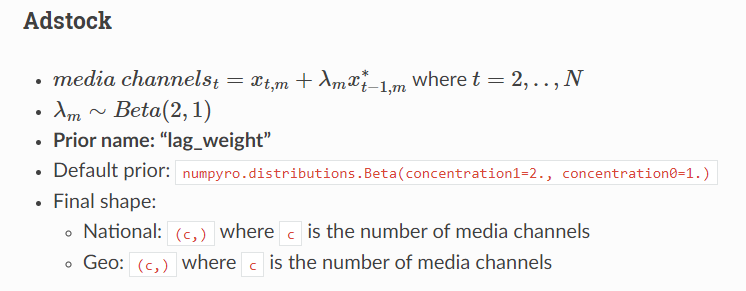

Hill-Adstock: Applies a sigmoid like function for diminishing returns to the output of the adstock function.

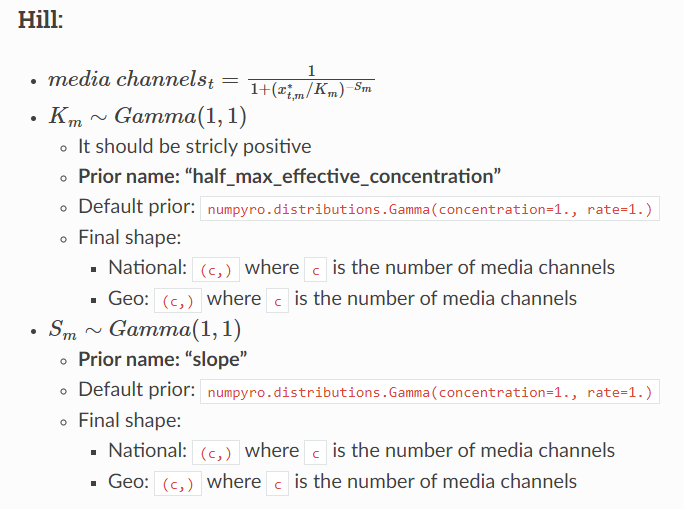


Carryover: Applies a causal convolution giving more weight to the near values than distant ones.

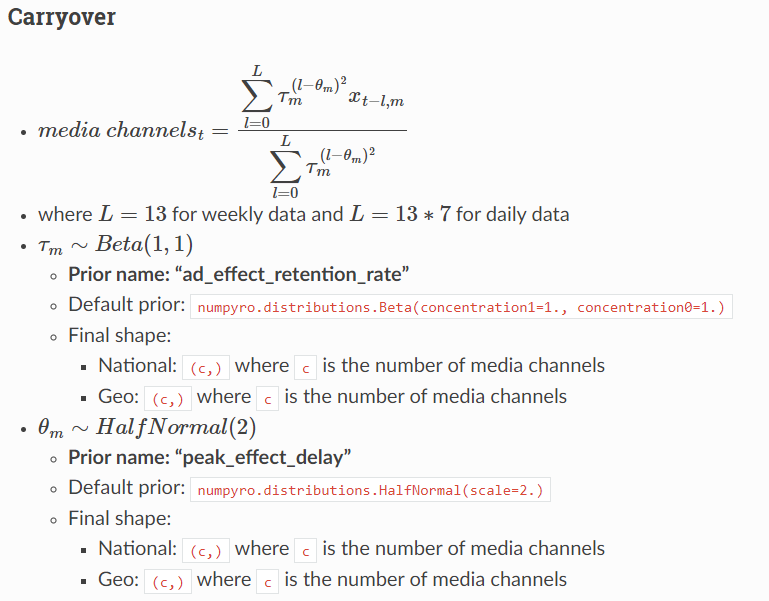

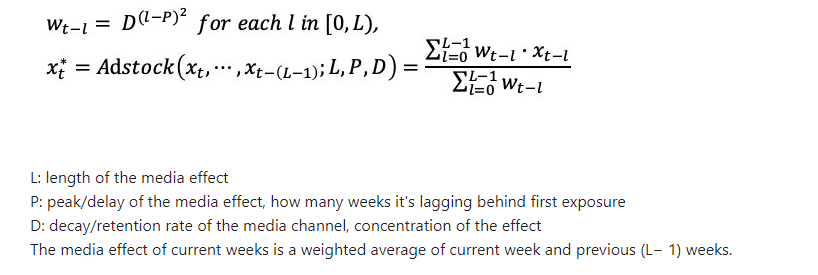


In [15]:
"""
Test for best ad-stock model

Error1: ValueError: The number of data channels provided must match the number of cost values.

"""

%time



adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1,2,3]



model_output_dict = {}

# try:
for model_name in adstock_models:
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(media=media_spend_train_scaled,
                media_prior=media_spend_scaled,
                target=target_train_scaled,
                extra_features=extra_train_scaled,
                number_warmup=100,
                number_samples=130,
                number_chains=10,
                degrees_seasonality=degrees,
                weekday_seasonality=False,
                seasonality_frequency=52,
                seed=1)
        
        mmm.print_summary()
        prediction = mmm.predict(
        media=media_spend_test_scaled,
        extra_features=extra_test_scaled,
        target_scaler=target_scaler)
        print("prediction.shape",prediction.shape)
        p = prediction.mean(axis=0)

        mape = mean_absolute_percentage_error(target_test, p)
        r2 = arviz.r2_score(target_test, p)
        # r2 = r2_score(target_test, p)
        print(f"model_name={model_name} degrees={degrees} MAPE={mape} R2={r2}")

        model_output_dict[model_name+"_"+str(degrees)] = (mape,r2)

            
# except Exception as e:
#     print(e)
print(model_output_dict)   


CPU times: total: 0 ns
Wall time: 0 ns


sample: 100%|██████████| 230/230 [00:26<00:00,  8.77it/s, 1023 steps of size 2.00e-03. acc. prob=0.96]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
 coef_extra_features[0]     -0.61      0.66     -0.58     -1.76      0.43    163.73      1.08
 coef_extra_features[1]      0.20      0.33      0.21     -0.36      0.70    290.51      1.03
 coef_extra_features[2]     -0.69      0.56     -0.71     -1.59      0.22    252.57      1.04
 coef_extra_features[3]     -0.08      0.19     -0.08     -0.40      0.21    324.06      1.02
 coef_extra_features[4]      0.45      0.64      0.46     -0.61      1.46     35.32      1.14
 coef_extra_features[5]     -0.13      0.82     -0.17     -1.41      1.22    127.29      1.07
 coef_extra_features[6]     -0.14      0.72     -0.12     -1.51      0.94    100.28      1.10
 coef_extra_features[7]      0.00      0.01      0.00     -0.00      0.01   1315.13      1.00
 coef_extra_features[8]      0.00      0.00      0.00     -0.01      0.01   1138.11      1.00
 coef_extra_features[9]      0.01      0.00      0.01      

sample: 100%|██████████| 230/230 [00:31<00:00,  7.39it/s, 1023 steps of size 1.65e-03. acc. prob=0.97]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
 coef_extra_features[0]     -0.49      0.71     -0.49     -1.67      0.67    146.20      1.04
 coef_extra_features[1]      0.16      0.40      0.15     -0.45      0.81    155.39      1.03
 coef_extra_features[2]     -0.69      0.66     -0.69     -1.68      0.43     87.12      1.10
 coef_extra_features[3]     -0.09      0.21     -0.09     -0.45      0.24    268.35      1.02
 coef_extra_features[4]      0.45      0.62      0.42     -0.51      1.44    115.11      1.06
 coef_extra_features[5]     -0.03      0.75     -0.05     -1.31      1.12    195.17      1.05
 coef_extra_features[6]      0.20      0.64      0.19     -0.90      1.22    105.71      1.09
 coef_extra_features[7]      0.00      0.01      0.00     -0.00      0.01   1100.15      1.00
 coef_extra_features[8]     -0.00      0.00     -0.00     -0.01      0.01   1237.25      1.00
 coef_extra_features[9]      0.01      0.00      0.01      

sample: 100%|██████████| 230/230 [03:07<00:00,  1.22it/s, 1023 steps of size 3.40e-03. acc. prob=0.95]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
 coef_extra_features[0]     -0.35      0.74     -0.35     -1.58      0.80    330.56      1.03
 coef_extra_features[1]      0.09      0.37      0.09     -0.49      0.70    362.29      1.02
 coef_extra_features[2]     -0.68      0.61     -0.68     -1.72      0.24    366.20      1.03
 coef_extra_features[3]     -0.20      0.22     -0.20     -0.57      0.15    502.42      1.02
 coef_extra_features[4]      0.47      0.63      0.48     -0.55      1.50    447.52      1.02
 coef_extra_features[5]      0.04      0.82      0.06     -1.36      1.28    137.93      1.08
 coef_extra_features[6]     -0.06      0.63     -0.05     -1.15      0.93    182.70      1.05
 coef_extra_features[7]      0.00      0.01      0.00     -0.01      0.01   1227.82      1.00
 coef_extra_features[8]      0.00      0.00      0.00     -0.01      0.01   1344.97      1.00
 coef_extra_features[9]      0.01      0.00      0.01      

sample: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s, 1023 steps of size 2.46e-03. acc. prob=0.94]



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.64      0.66     -0.63     -1.75      0.38    498.21      1.02
             coef_extra_features[1]      0.28      0.34      0.28     -0.35      0.77    391.62      1.02
             coef_extra_features[2]     -0.87      0.64     -0.87     -1.83      0.27    458.87      1.01
             coef_extra_features[3]      0.21      0.19      0.21     -0.10      0.52    677.06      1.00
             coef_extra_features[4]      0.68      0.63      0.68     -0.32      1.74    362.35      1.02
             coef_extra_features[5]     -0.01      0.83     -0.00     -1.39      1.24    268.93      1.03
             coef_extra_features[6]      0.01      0.68      0.01     -1.13      1.07    227.44      1.03
             coef_extra_features[7]      0.01      0.01      0.01      0.00      0.02   1200.21      1.00
             coef_extra_features[8]      0.00

sample: 100%|██████████| 230/230 [00:24<00:00,  9.24it/s, 1023 steps of size 4.94e-03. acc. prob=0.95]



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.50      0.67     -0.49     -1.58      0.60    352.27      1.02
             coef_extra_features[1]      0.17      0.36      0.16     -0.41      0.72    437.84      1.02
             coef_extra_features[2]     -0.84      0.61     -0.82     -1.84      0.17    474.96      1.02
             coef_extra_features[3]      0.15      0.20      0.15     -0.19      0.46    672.14      1.01
             coef_extra_features[4]      0.69      0.62      0.70     -0.26      1.69    583.89      1.00
             coef_extra_features[5]     -0.01      0.82     -0.02     -1.40      1.25    265.88      1.04
             coef_extra_features[6]      0.11      0.68      0.12     -1.03      1.18    246.62      1.04
             coef_extra_features[7]      0.01      0.01      0.01      0.00      0.02   1455.79      1.00
             coef_extra_features[8]     -0.00

sample: 100%|██████████| 230/230 [00:29<00:00,  7.76it/s, 1023 steps of size 4.33e-03. acc. prob=0.92]



                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.43      0.70     -0.41     -1.55      0.73    232.46      1.04
             coef_extra_features[1]      0.15      0.36      0.15     -0.48      0.70    357.38      1.02
             coef_extra_features[2]     -0.74      0.65     -0.74     -1.92      0.18    371.45      1.03
             coef_extra_features[3]      0.05      0.21      0.04     -0.29      0.40    504.24      1.02
             coef_extra_features[4]      0.59      0.61      0.58     -0.48      1.55    255.59      1.04
             coef_extra_features[5]      0.09      0.79      0.09     -1.20      1.36    215.33      1.02
             coef_extra_features[6]      0.03      0.73      0.03     -1.26      1.13    162.89      1.07
             coef_extra_features[7]      0.01      0.01      0.01      0.00      0.02   1371.54      1.00
             coef_extra_features[8]      0.00

sample: 100%|██████████| 230/230 [01:02<00:00,  3.67it/s, 1023 steps of size 2.22e-03. acc. prob=0.95]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.46      0.28      0.46      0.01      0.86     64.82      1.12
ad_effect_retention_rate[1]      0.51      0.30      0.50      0.09      1.00     97.83      1.12
ad_effect_retention_rate[2]      0.37      0.33      0.27      0.00      0.89     20.82      1.26
ad_effect_retention_rate[3]      0.52      0.29      0.55      0.11      1.00    180.88      1.06
ad_effect_retention_rate[4]      0.52      0.29      0.54      0.11      1.00     99.10      1.10
ad_effect_retention_rate[5]      0.34      0.24      0.31      0.00      0.68    153.67      1.07
ad_effect_retention_rate[6]      0.53      0.29      0.56      0.10      0.97    119.95      1.10
ad_effect_retention_rate[7]      0.47      0.28      0.47      0.00      0.86    196.12      1.02
ad_effect_retention_rate[8]      0.49      0.27      0.49      0.00      0.86    234.56      1.03
ad_effect_retention

sample: 100%|██████████| 230/230 [01:14<00:00,  3.09it/s, 1023 steps of size 2.05e-03. acc. prob=0.96]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.49      0.30      0.45      0.10      1.00     57.93      1.13
ad_effect_retention_rate[1]      0.48      0.28      0.47      0.02      0.89    187.23      1.04
ad_effect_retention_rate[2]      0.30      0.28      0.21      0.00      0.77     84.13      1.11
ad_effect_retention_rate[3]      0.50      0.27      0.52      0.07      0.92    172.90      1.05
ad_effect_retention_rate[4]      0.56      0.29      0.58      0.14      1.00    159.92      1.06
ad_effect_retention_rate[5]      0.34      0.23      0.30      0.00      0.69     98.68      1.09
ad_effect_retention_rate[6]      0.54      0.28      0.54      0.14      1.00     90.51      1.11
ad_effect_retention_rate[7]      0.51      0.29      0.52      0.08      0.96    140.99      1.04
ad_effect_retention_rate[8]      0.46      0.29      0.45      0.00      0.86    125.04      1.05
ad_effect_retention

sample: 100%|██████████| 230/230 [01:14<00:00,  3.10it/s, 1023 steps of size 2.45e-03. acc. prob=0.97]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.47      0.31      0.43      0.07      1.00     26.33      1.27
ad_effect_retention_rate[1]      0.50      0.30      0.49      0.09      0.99    106.12      1.10
ad_effect_retention_rate[2]      0.40      0.31      0.35      0.00      0.88     63.57      1.15
ad_effect_retention_rate[3]      0.50      0.30      0.48      0.00      0.91     37.69      1.18
ad_effect_retention_rate[4]      0.49      0.30      0.48      0.01      0.90     30.56      1.20
ad_effect_retention_rate[5]      0.29      0.20      0.26      0.00      0.59    133.79      1.07
ad_effect_retention_rate[6]      0.47      0.28      0.46      0.04      0.90    113.54      1.09
ad_effect_retention_rate[7]      0.50      0.28      0.51      0.05      0.89    158.33      1.07
ad_effect_retention_rate[8]      0.46      0.27      0.45      0.02      0.86    152.79      1.05
ad_effect_retention

In [50]:
"""
Analyse all models: All their accuracies (Mape) and R2 values are similar.

Carryover model with degree 3 has the highest accuracy in terms of both MAPE and R2. We will go ahead with this.
"""

print(model_output_dict)

model_name="carryover"
degrees = 2

mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
mmm.fit(media=media_spend_train_scaled,
        media_prior=media_spend_scaled,
        target=target_train_scaled,
        extra_features=extra_train_scaled,
        number_warmup=100,
        number_samples=130,
        number_chains=4,
        degrees_seasonality=degrees,
        weekday_seasonality=False,
        seasonality_frequency=52,
        seed=1)

mmm.print_summary()
prediction = mmm.predict(
media=media_spend_test_scaled,
extra_features=extra_test_scaled,
target_scaler=target_scaler)
print("prediction.shape",prediction.shape)
p = prediction.mean(axis=0)

mape = mean_absolute_percentage_error(target_test, p)
r2 = arviz.r2_score(target_test, p)
# r2 = r2_score(target_test, p)
print(f"model_name={model_name} degrees={degrees} MAPE={mape} R2={r2}")


sample: 100%|██████████| 230/230 [01:27<00:00,  2.64it/s, 1023 steps of size 4.91e-03. acc. prob=0.97]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.51      0.29      0.47      0.13      1.00     64.10      1.14
ad_effect_retention_rate[1]      0.48      0.29      0.48      0.11      1.00     63.41      1.07
ad_effect_retention_rate[2]      0.29      0.25      0.20      0.01      0.71     33.21      1.09
ad_effect_retention_rate[3]      0.47      0.27      0.44      0.06      0.93     98.55      1.02
ad_effect_retention_rate[4]      0.44      0.33      0.36      0.01      0.94      9.42      1.21
ad_effect_retention_rate[5]      0.37      0.28      0.31      0.00      0.81      8.17      1.20
ad_effect_retention_rate[6]      0.47      0.26      0.48      0.02      0.84    120.24      1.03
ad_effect_retention_rate[7]      0.47      0.26      0.45      0.04      0.86    136.01      1.03
ad_effect_retention_rate[8]      0.45      0.28      0.42      0.01      0.86     62.15      1.09
ad_effect_retention

In [51]:
{'channel_'+str(i):media_spend_cols[i] for i in range(len(media_spend_cols))}

{'channel_0': 'media_spend_direct_mail',
 'channel_1': 'media_spend_insert',
 'channel_2': 'media_spend_newspaper',
 'channel_3': 'media_spend_dig_audio',
 'channel_4': 'media_spend_radio',
 'channel_5': 'media_spend_tv',
 'channel_6': 'media_spend_dig_video',
 'channel_7': 'media_spend_social_media',
 'channel_8': 'media_spend_online display',
 'channel_9': 'media_spend_sem'}

### Select best model and run diagnostics

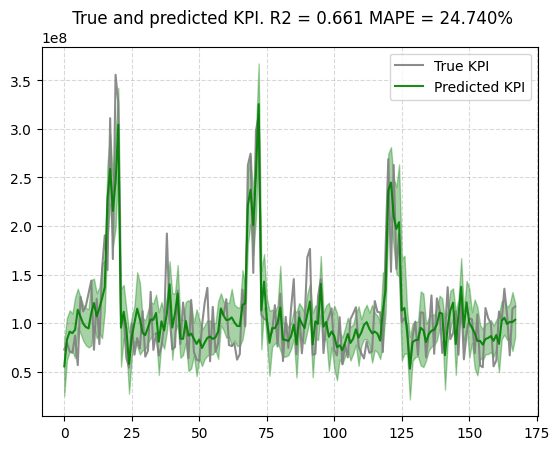

In [52]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

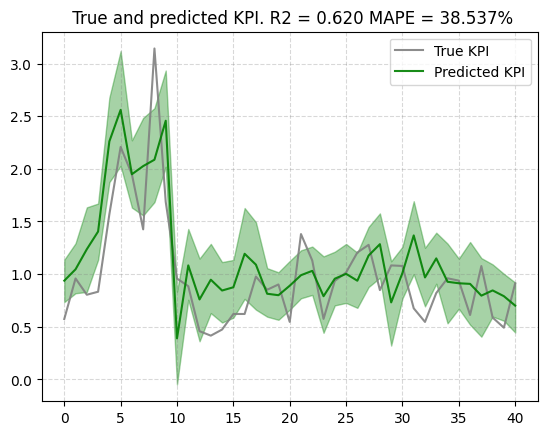

In [53]:
new_predictions = mmm.predict(media=media_spend_test_scaled,
                              extra_features=extra_test_scaled,
                            #   target_scaler=target_scaler,
                              seed=1)

plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target_test))

In [54]:
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x



In [55]:
# L = 12
# D = 0.54
# P = 1.01 

# x = [500,550,400,600,400]
# carryover_tv = apply_adstock(x, L, P, D)


# plt.plot(x)
# plt.plot(carryover_tv)
# plt.show()

### Plotting Prior and Posterior Distributions

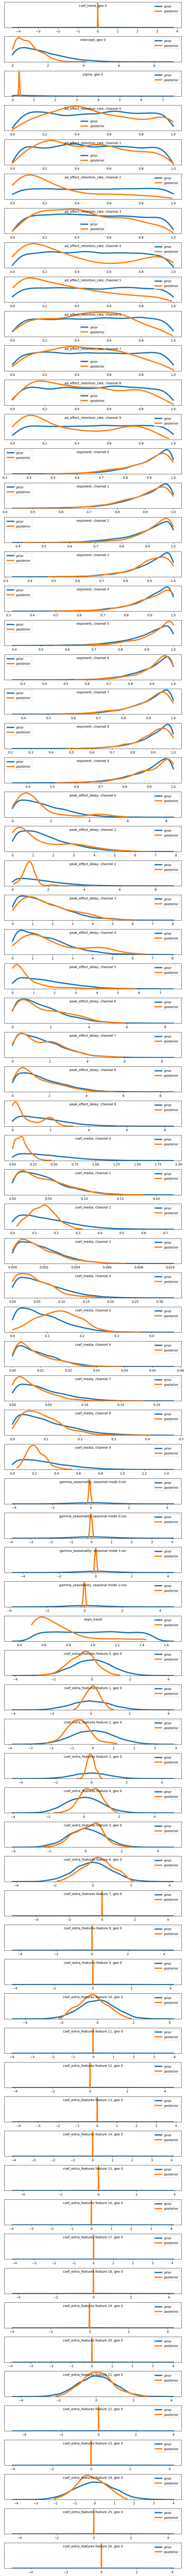

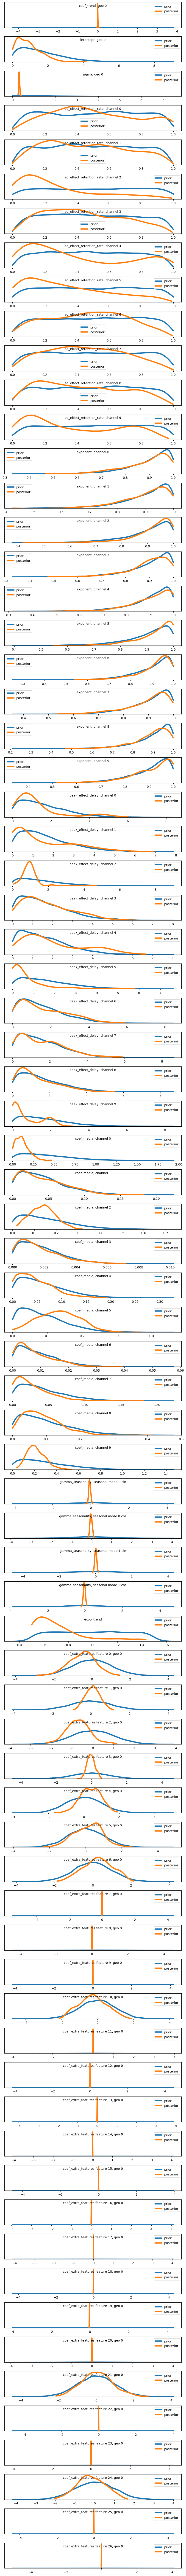

In [56]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

In [57]:
"""
Bug- to be fixed
"""

# plot.plot_media_channel_posteriors(media_mix_model=mmm,channel_names=media_spend_cols)

'\nBug- to be fixed\n'

### Baseline-contribution chart across the time periods

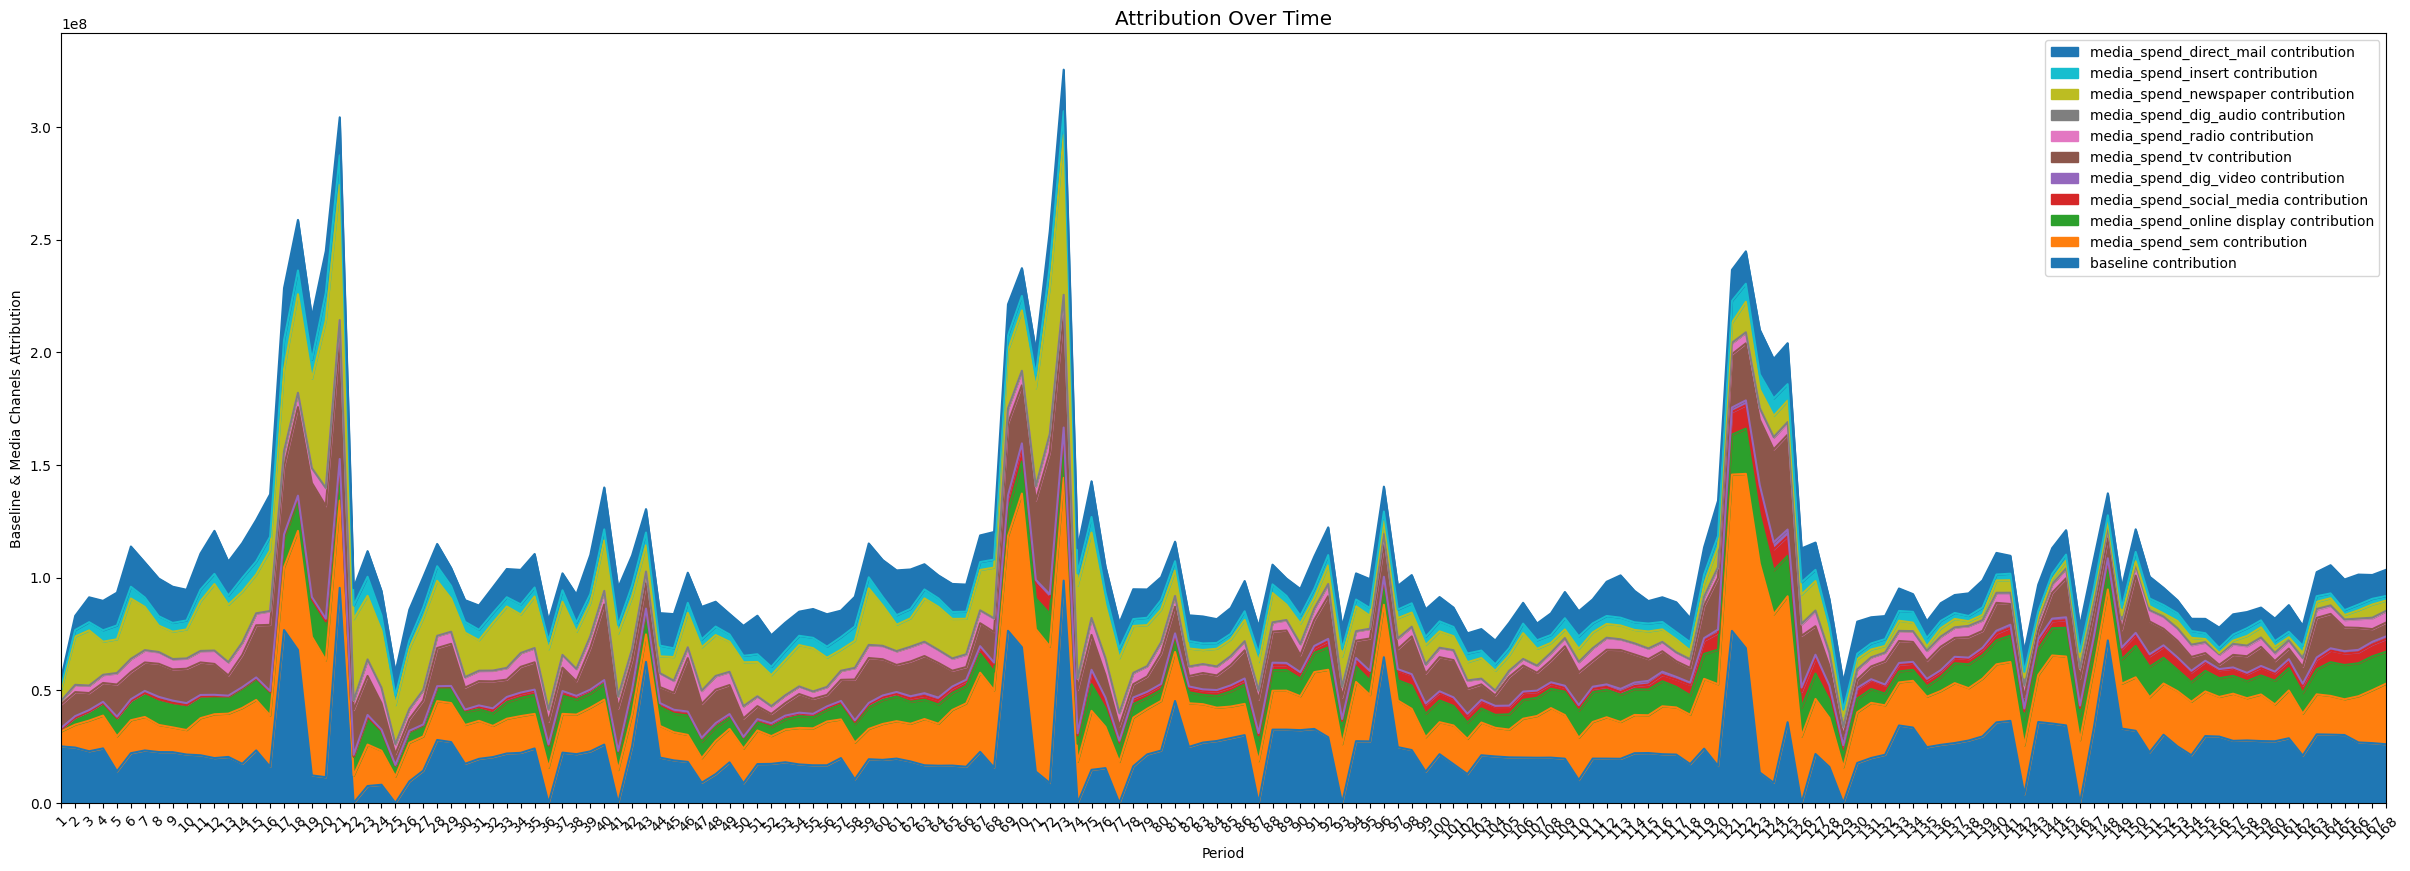

In [58]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=costs_scaler)
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = media_spend_cols
                                                )

### Media contribution and ROI contribution per channel

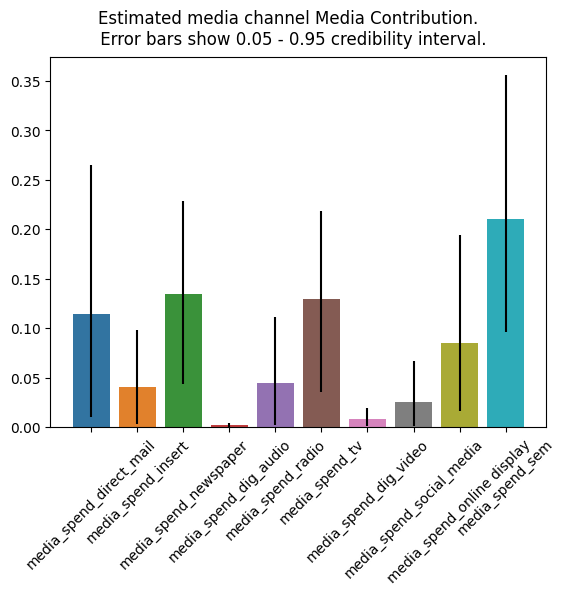

<Figure size 2000x2000 with 0 Axes>

In [59]:
plt.figure(figsize=(20,20))
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution", channel_names=media_spend_cols,interval_mid_range= 0.9)

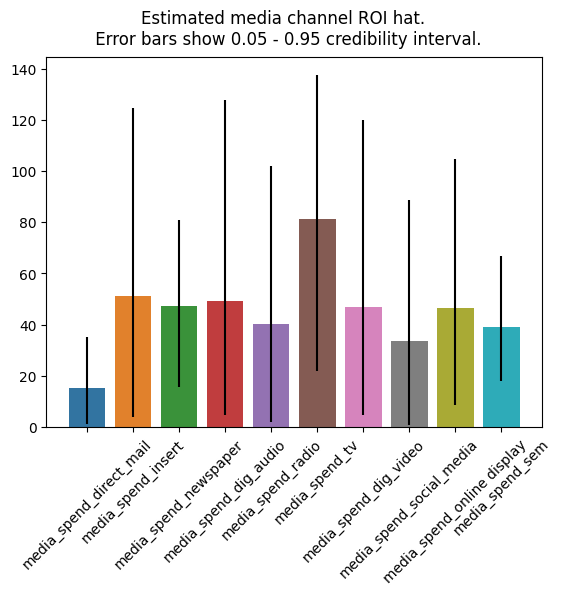

<Figure size 2000x2000 with 0 Axes>

In [60]:
plt.figure(figsize=(20,20))
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_spend_cols,interval_mid_range= 0.9)

### Response Curves

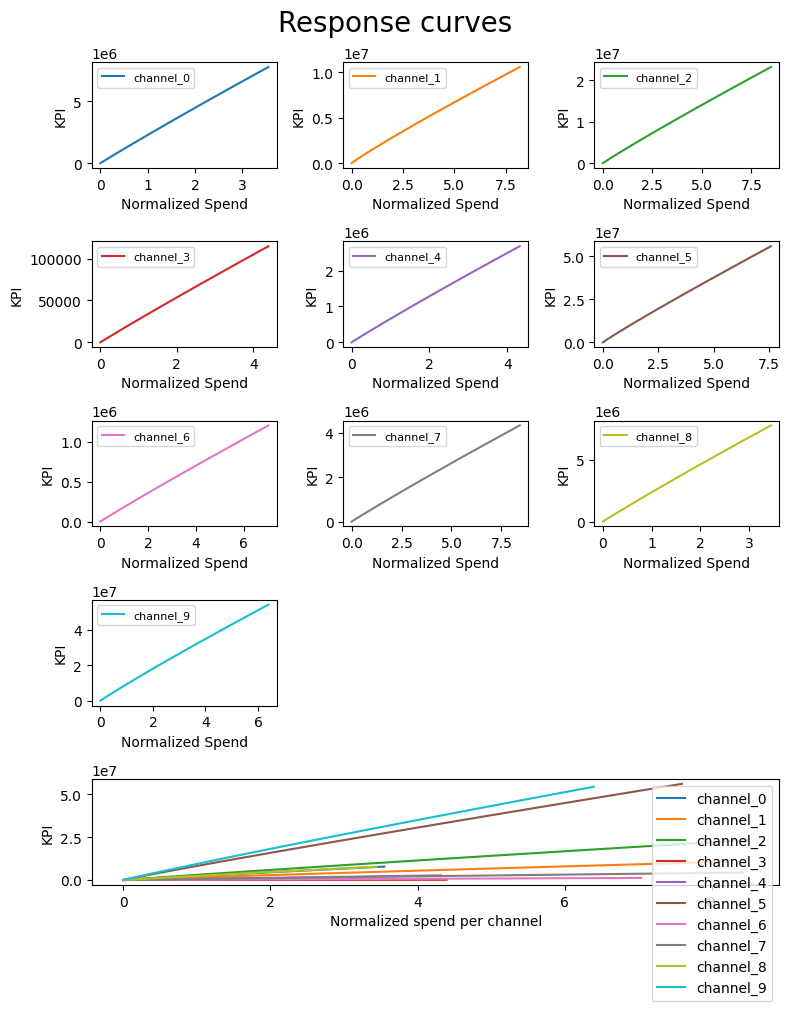

In [61]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler,seed = 1)

# Budget Optimization - Find the best media allocation based on MMM model, prices and a budget.

Conducted for n_time_periods = 10.

In [62]:
""" 
Define the number of periods for which we want to run optimization

"""

n_media_channels = 10
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 10
media_data = X[media_spend_cols].to_numpy()

budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [63]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features= extra_scaler.transform(X[extra_features_cols].to_numpy())[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1275043579.923361
            Iterations: 61
            Function evaluations: 1197
            Gradient evaluations: 57


In [64]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([4721750.  ,  607438.1 ,  297541.34,   60843.18, 1547527.2 ,
       1738450.  ,  256608.42, 1479583.8 , 3391919.8 , 9387534.  ],      dtype=float32)

In [65]:

# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([5740742.   ,  552671.1  ,  270714.84 ,   55357.527, 1408001.4  ,
       1581710.4  ,  233472.44 , 2019275.8  , 3086102.5  , 8541149.   ],      dtype=float32)

In [66]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(23489196., dtype=float32), Array(23489196., dtype=float32))

In [67]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(23489196., dtype=float32), Array(23489196., dtype=float32))

In [68]:
{'channel_'+str(i):media_spend_cols[i] for i in range(len(media_spend_cols))}

{'channel_0': 'media_spend_direct_mail',
 'channel_1': 'media_spend_insert',
 'channel_2': 'media_spend_newspaper',
 'channel_3': 'media_spend_dig_audio',
 'channel_4': 'media_spend_radio',
 'channel_5': 'media_spend_tv',
 'channel_6': 'media_spend_dig_video',
 'channel_7': 'media_spend_social_media',
 'channel_8': 'media_spend_online display',
 'channel_9': 'media_spend_sem'}

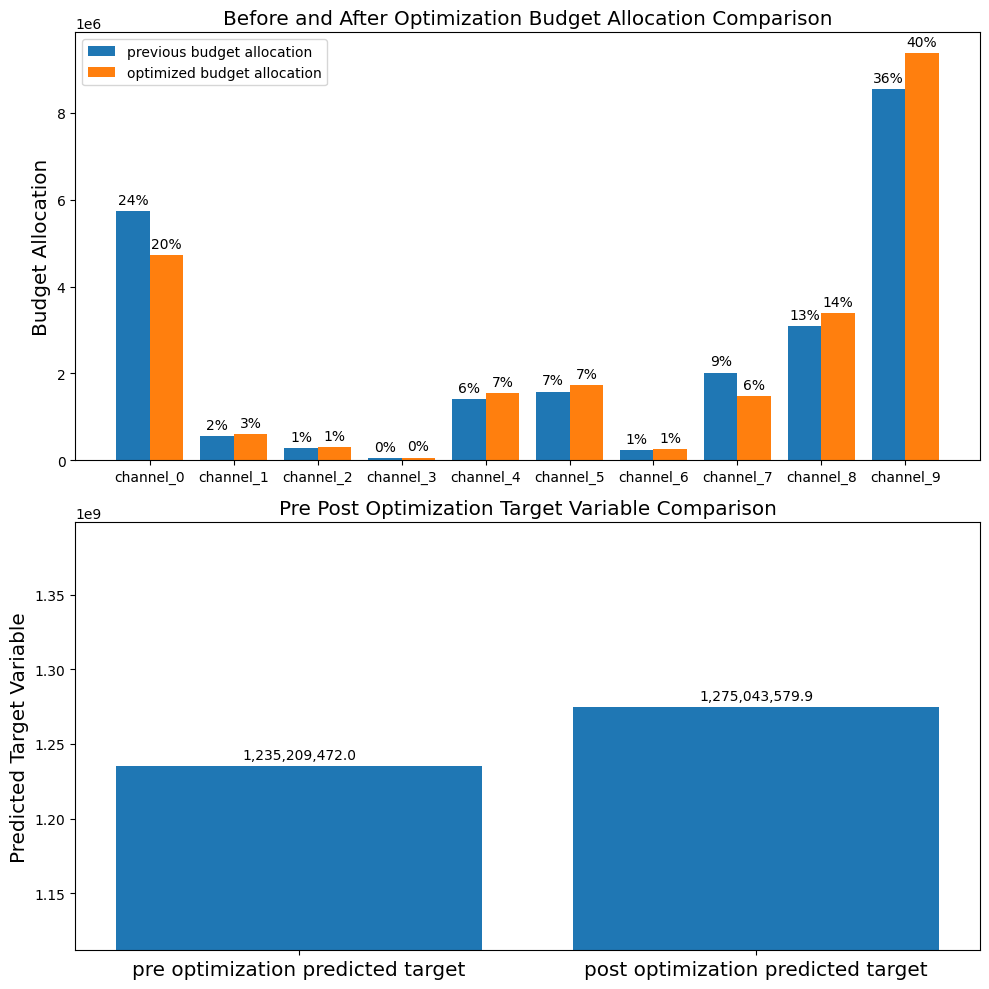

In [69]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

## Save Model

In [70]:
# file_path = "mmm_carryover_2_12_apr.pkl"
# utils.save_model(media_mix_model=mmm, file_path=file_path)

In [71]:
# file_path = "mmm_adstock_2_21_apr.pkl"
# utils.save_model(media_mix_model=mmm, file_path=file_path)